In [2]:
import os
import face_recognition
from PIL import Image
import cv2
import math
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset,random_split,Subset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch.optim as optim
import random
import numpy as np

In [24]:
# Move model to GPU if available
device = torch.device("cuda:0")
print(device)

# For reproducability
seed = 33

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda:0


In [ ]:
#from video get frames
def capture_frames(video_path, output_folder,video_name, num_frames):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(total_frames)
    
    interval = math.floor(total_frames // num_frames)
    if interval == 0:
        interval = 1
    # print(interval)
    
    frame_count = 0
    success = True
    frame_number = 0
    while success and frame_number < total_frames:
        # Set the frame number to read
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        
        # Read a frame from the video
        success, frame = cap.read()
        
        # Check if its time to capture a frame
        if frame_number != 0 and interval !=0 and frame_number % interval == 0 and success:
            frame_path = os.path.join(output_folder, f"{video_name}_{frame_count}.jpg")
            cv2.imwrite(frame_path, frame)
            # print(f"Saved frame {frame_count}")
            
            frame_count += 1

        frame_number += interval

    cap.release()
    print("Frame capture completed.")

def capture_frames_from_folder(video_folder, output_folder, num_frames=10):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the video folder
    for file_name in os.listdir(video_folder):
        if file_name.endswith(('.mp4')):
            video_path = os.path.join(video_folder, file_name)
            video_name = os.path.splitext(file_name)[0]
            print(video_name)
            capture_frames(video_path, output_folder, video_name, num_frames)

In [ ]:
video_path = "train/real"
output_folder = "train/real_frame"
num_frames_to_capture = 6

capture_frames_from_folder(video_path, output_folder, num_frames=num_frames_to_capture)

In [ ]:
def extract_faces_from_frames(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(input_folder, filename)
            image = face_recognition.load_image_file(image_path)

            # Find all face locations in the image
            face_locations = face_recognition.face_locations(image)

            # Extract and save faces
            for i, (top, right, bottom, left) in enumerate(face_locations):
                # only extract faces greater than 75x75 pixels --> helps to ignore wrong faces from background objects
                if (bottom - top > 75) and (right - left > 75):
                    face_roi = image[top:bottom, left:right]
                    face_path = os.path.join(
                        output_folder, f"{os.path.splitext(filename)[0]}_face_{i}.jpg"
                    )
                    face_image = Image.fromarray(face_roi)
                    face_image.save(face_path)
                    print(f"Saved face {i} from {filename}")

input_folder = "train/fake_frame"
output_folder = "train/fake_face"


extract_faces_from_frames(input_folder, output_folder)

In [3]:
class DeepfakeDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Load data paths and labels
        for label, subdir in enumerate(['real_face', 'fake_face']):
            dir_path = os.path.join(self.root_dir, subdir)
            files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            labels = [label] * len(files)  # 0 for real, 1 for fake
            self.data.extend(zip(files, labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 channels

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset = DeepfakeDetectionDataset(root_dir='train',transform=transform)

In [6]:
# Split sizes
total_size = len(dataset)
# print(total_size)
# train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
train_size = int(0.8 * total_size)
test_size = int(0.1 * total_size)
val_size = total_size - train_size - test_size  # Remainder for validation

print(train_size)
print(val_size)
print(test_size)
total_samples = len(dataset)
indices = torch.randperm(total_samples)[:32]  # Randomly shuffle and select the first 100 indices

small_train_dataset = Subset(dataset, indices)
small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)

# Split the dataset
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1101
139
137


In [7]:
def inspect_dataloader(dataloader):
    # Get the first batch
    images, labels = next(iter(dataloader))
    
    # Print the shapes and labels of the batch
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")

print("Inspecting Training DataLoader:")
inspect_dataloader(train_loader)

print("\nInspecting Validation DataLoader:")
inspect_dataloader(val_loader)

print("\nInspecting Testing DataLoader:")
inspect_dataloader(test_loader)

Inspecting Training DataLoader:
Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1])

Inspecting Validation DataLoader:
Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

Inspecting Testing DataLoader:
Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1])


In [34]:
# Load a pre-trained ResNet50 model
model = models.resnet152(weights="ResNet152_Weights.DEFAULT")

num_ftrs = model.fc.in_features
#  nn.Sequential(nn.Linear(num_ftrs, classCount), nn.Sigmoid())
model.fc =nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 2),
    nn.Sigmoid())

# model = model.to(device)

criterion = nn.CrossEntropyLoss()
#L2 Regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [17]:
def train_model(model, criterion, optimizer, dataloader, num_epochs):
      # Set model to training mode
    patience_counter = 0
    best_val_loss = 1
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        
        for inputs, labels in dataloader:
            # print(f"Input batch shape: {inputs.shape}")
            # print(f"Labels batch shape: {labels.shape}")
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct_preds.double() / len(dataloader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        

    print('Training complete')
    return model


In [20]:
train_model(model, criterion, optimizer, train_loader, num_epochs=10)

Epoch 1/10, Loss: 0.5309, Acc: 0.7793
Epoch 2/10, Loss: 0.5199, Acc: 0.7938
Epoch 3/10, Loss: 0.5201, Acc: 0.7938
Epoch 4/10, Loss: 0.5194, Acc: 0.7938
Epoch 5/10, Loss: 0.5194, Acc: 0.7938
Epoch 6/10, Loss: 0.5196, Acc: 0.7938
Epoch 7/10, Loss: 0.5194, Acc: 0.7938
Epoch 8/10, Loss: 0.5194, Acc: 0.7938
Epoch 9/10, Loss: 0.5194, Acc: 0.7938
Epoch 10/10, Loss: 0.5194, Acc: 0.7938
Training complete


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
#Save weights
torch.save(model.state_dict(), 'weights/CE_LR5e-4_EPOCH25_ES_Resnet152.pth')

In [ ]:
# Load weights
model.load_state_dict(torch.load('weights/BCE_LR5e-4_EPOCH25_ES.pth'))

In [22]:
def validate(model, criterion, validate_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(val_loss)
    return val_loss / len(validate_loader)

def evaluate(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:

            outputs = model(inputs)
            print(outputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return accuracy, precision, recall, f1

# Evaluate the model
validate(model,criterion,val_loader)
evaluate(model, test_loader)
# Assuming you've defined test_loader and validate_loader DataLoaders

val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader)
print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader)
print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


2.6771035492420197
tensor([[1.0273e-09, 1.0000e+00],
        [3.9283e-13, 1.0000e+00],
        [1.8227e-10, 1.0000e+00],
        [9.2898e-14, 1.0000e+00],
        [6.1327e-11, 1.0000e+00],
        [1.3830e-09, 1.0000e+00],
        [1.5773e-10, 1.0000e+00],
        [1.5354e-09, 1.0000e+00],
        [4.3204e-10, 1.0000e+00],
        [7.1630e-12, 1.0000e+00],
        [6.7378e-13, 1.0000e+00],
        [4.4972e-11, 1.0000e+00],
        [3.7852e-13, 1.0000e+00],
        [4.4091e-13, 1.0000e+00],
        [3.5533e-10, 1.0000e+00],
        [2.5694e-10, 1.0000e+00],
        [7.2403e-09, 1.0000e+00],
        [9.7603e-09, 1.0000e+00],
        [5.5188e-11, 1.0000e+00],
        [1.2857e-09, 1.0000e+00],
        [4.6870e-12, 1.0000e+00],
        [1.7440e-13, 1.0000e+00],
        [3.3371e-08, 1.0000e+00],
        [3.3193e-14, 1.0000e+00],
        [8.3722e-12, 1.0000e+00],
        [1.1185e-08, 1.0000e+00],
        [1.3234e-07, 1.0000e+00],
        [1.3053e-13, 1.0000e+00],
        [6.8098e-10, 1.0000e+

In [4]:
from torch.utils.tensorboard import SummaryWriter
# Directory where your .pth files are stored
directory = 'weights'

# Initialize a SummaryWriter instance
writer = SummaryWriter('runs/ai_project')

# Function to log model weights to TensorBoard
def log_model_to_tensorboard(file_path):
    checkpoint = torch.load(file_path, map_location='cpu')
    
    # Extracting file name without extension to use as a run name
    run_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Initialize a SummaryWriter for this specific file
    writer = SummaryWriter(f'runs/{run_name}')
    
    # Check for the presence of 'state_dict', use the checkpoint itself as fallback
    model_state = checkpoint.get('state_dict', checkpoint)
    
    # Assuming model_state is a dictionary of tensors
    if isinstance(model_state, dict):
        for param_tensor in model_state:
            writer.add_histogram(param_tensor, model_state[param_tensor], 0)

    # Log other metrics such as epoch and loss if available
    epoch = checkpoint.get('epoch', 0)
    best_loss = checkpoint.get('best_loss', float('inf'))
    writer.add_scalar('training/epoch', epoch, 0)
    writer.add_scalar('training/best_loss', best_loss, 0)

    # Optionally, log optimizer state if it's part of the checkpoint
    if 'optimizer' in checkpoint:
        optimizer_state = checkpoint['optimizer']
        # This assumes optimizer state includes some scalar values you want to log
        for key, value in optimizer_state.items():
            if isinstance(value, (float, int)):  # Make sure to log only scalar values
                writer.add_scalar(f'optimizer/{key}', value, 0)

    # Close the writer to flush all the data to disk
    writer.close()

# Process each .pth file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pth"):
        file_path = os.path.join(directory, filename)
        log_model_to_tensorboard(file_path)

In [6]:
checkpoint = torch.load('weights/BCE_LR1E-3_EPOCH10.pth', map_location='cpu')
print(checkpoint.keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

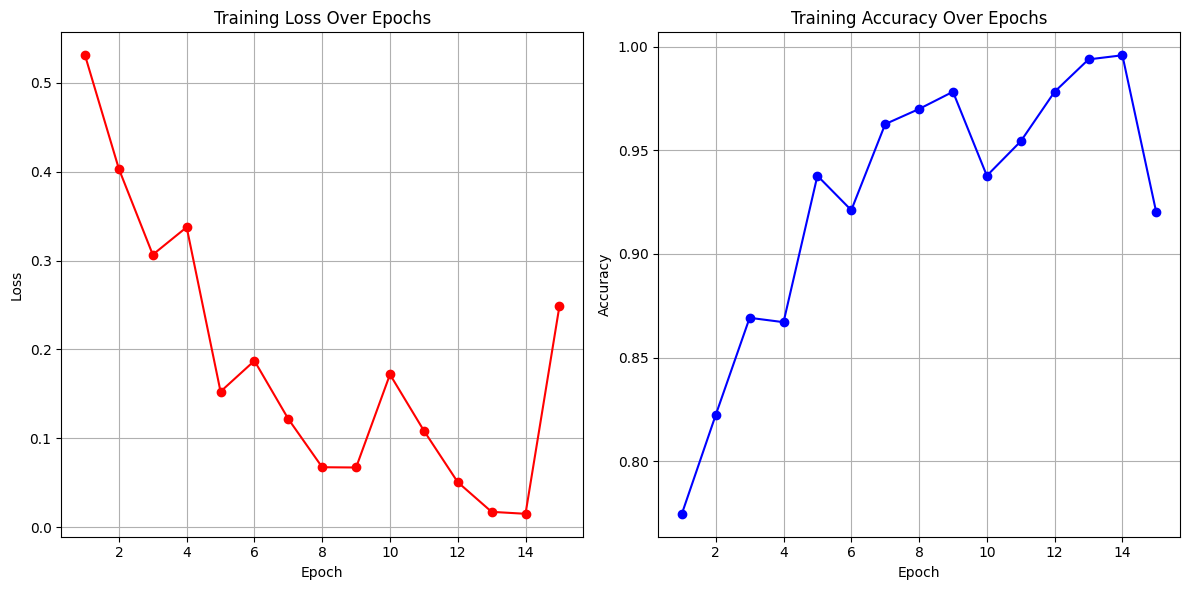

In [8]:
import matplotlib.pyplot as plt

# Training data
epochs = list(range(1, 16))
losses = [0.5311, 0.4032, 0.3067, 0.3376, 0.1526, 0.1873, 0.1218, 0.0675, 0.0672, 0.1719, 0.1087, 0.0507, 0.0173, 0.0151, 0.2486]
accuracies = [0.7747, 0.8224, 0.8692, 0.8671, 0.9377, 0.9211, 0.9626, 0.9699, 0.9782, 0.9377, 0.9543, 0.9782, 0.9938, 0.9958, 0.9200]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Loss', marker='o', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy', marker='o', color='blue')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

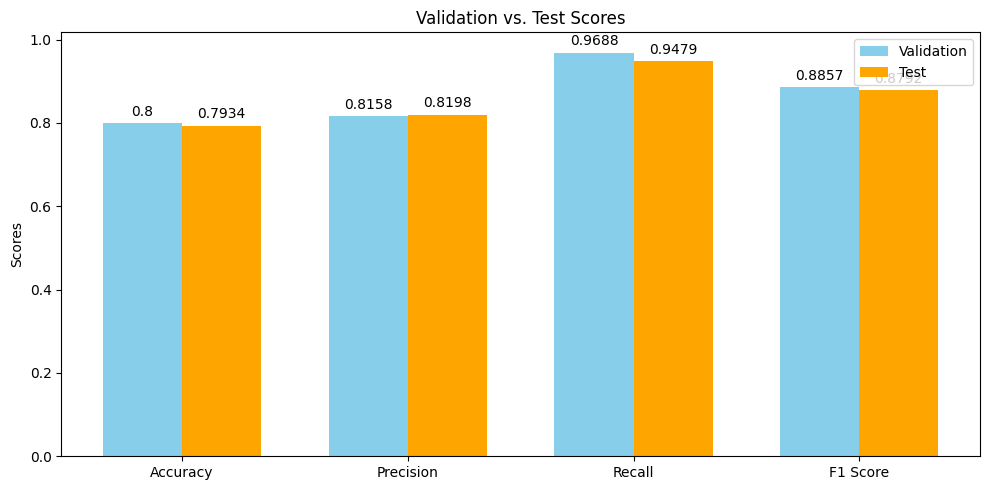

In [10]:
import matplotlib.pyplot as plt

# Validation and Test Scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
validation_scores = [0.8000, 0.8158, 0.9688, 0.8857]
test_scores = [0.7934, 0.8198, 0.9479, 0.8792]

x = list(range(len(metrics)))  # Convert range to list for arithmetic operations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar([xi - width/2 for xi in x], validation_scores, width, label='Validation', color='skyblue')
rects2 = ax.bar([xi + width/2 for xi in x], test_scores, width, label='Test', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Validation vs. Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Optionally add text labels above bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()


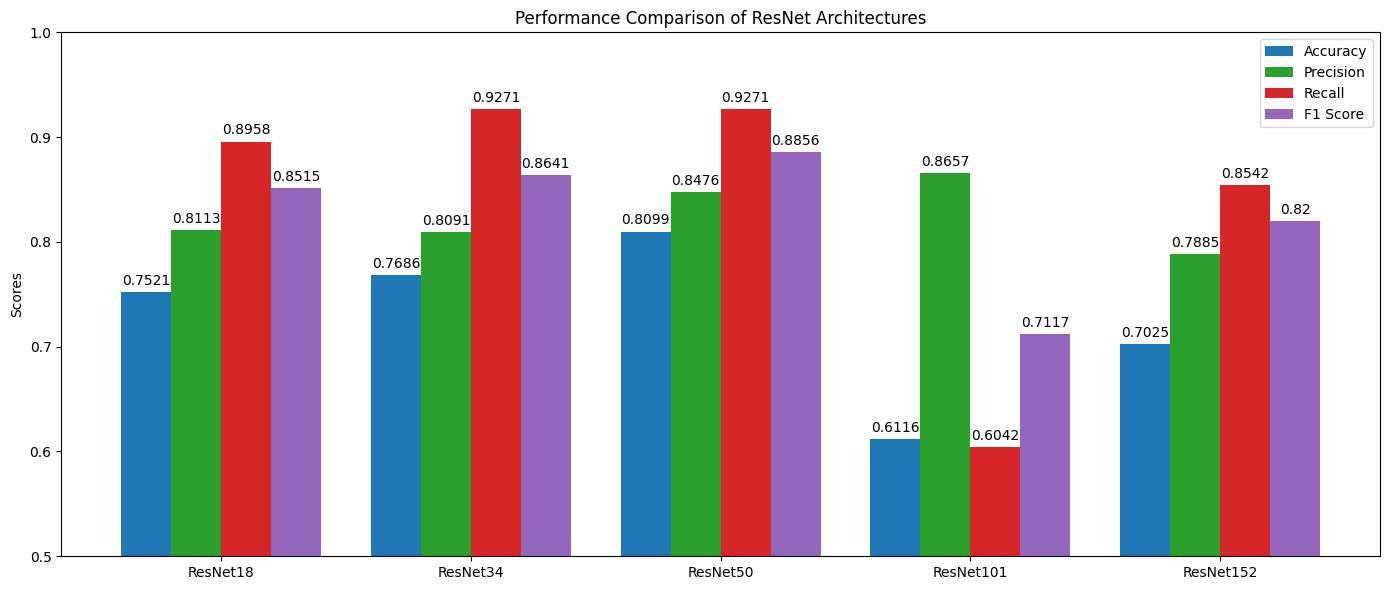

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ResNet Architectures and their performance metrics
resnets = ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
accuracy = [0.7521, 0.7686, 0.8099, 0.6116, 0.7025]
precision = [0.8113, 0.8091, 0.8476, 0.8657, 0.7885]
recall = [0.8958, 0.9271, 0.9271, 0.6042, 0.8542]
f1_scores = [0.8515, 0.8641, 0.8856, 0.7117, 0.8200]

x = np.arange(len(resnets))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of ResNet Architectures')
ax.set_xticks(x)
ax.set_xticklabels(resnets)
ax.legend()

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)
ax.set_ylim(0.5, 1.0)
fig.tight_layout()
plt.show()

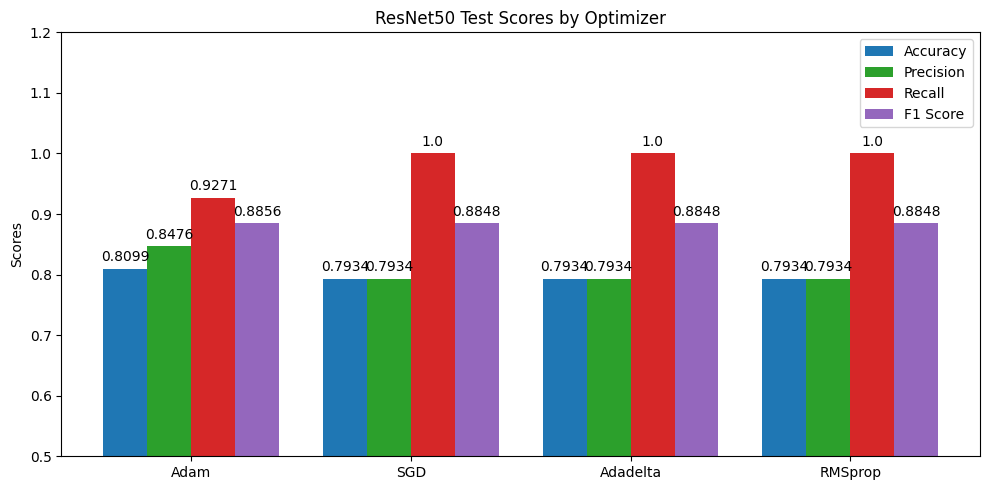

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Optimizers and their performance metrics
optimizers = ['Adam', 'SGD', 'Adadelta', 'RMSprop']
accuracy = [0.8099, 0.7934, 0.7934, 0.7934]
precision = [0.8476, 0.7934, 0.7934, 0.7934]
recall = [0.9271, 1.0000, 1.0000, 1.0000]
f1_scores = [0.8856, 0.8848, 0.8848, 0.8848]

x = np.arange(len(optimizers))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ResNet50 Test Scores by Optimizer')
ax.set_xticks(x)
ax.set_xticklabels(optimizers)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()


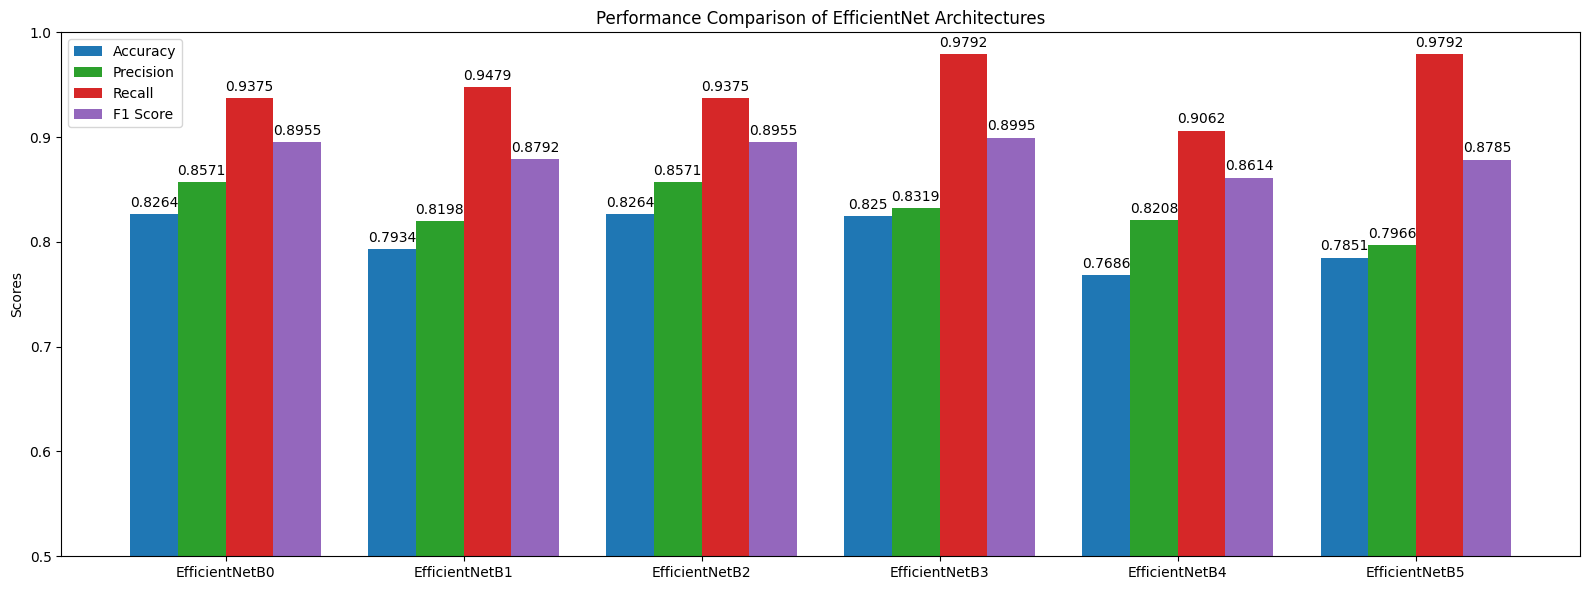

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# EfficientNet Architectures and their performance metrics
efficientnets = ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5']
accuracy = [0.8264, 0.7934, 0.8264, 0.8250, 0.7686, 0.7851]
precision = [0.8571, 0.8198, 0.8571, 0.8319, 0.8208, 0.7966]
recall = [0.9375, 0.9479, 0.9375, 0.9792, 0.9062, 0.9792]
f1_scores = [0.8955, 0.8792, 0.8955, 0.8995, 0.8614, 0.8785]

x = np.arange(len(efficientnets))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of EfficientNet Architectures')
ax.set_xticks(x)
ax.set_xticklabels(efficientnets)
ax.legend()

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)
ax.set_ylim(0.5, 1.0)

fig.tight_layout()
plt.show()


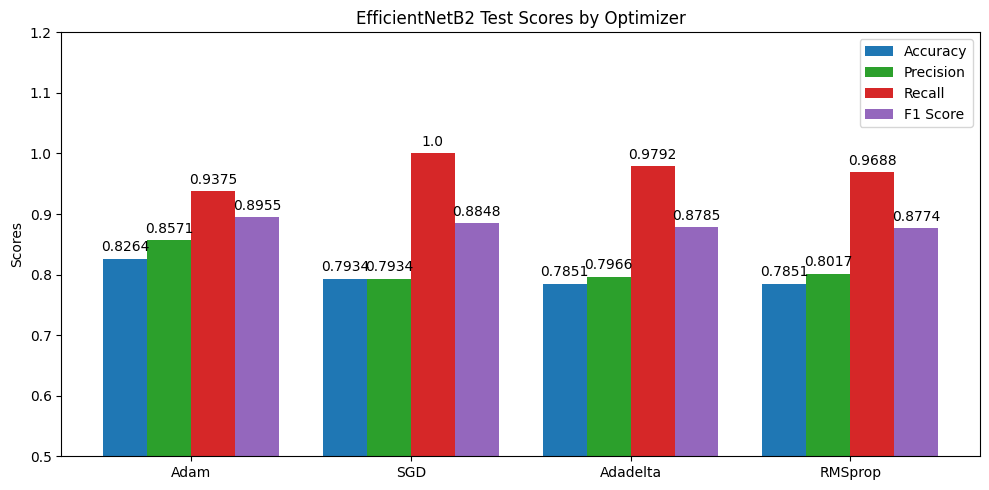

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Optimizers and their performance metrics
optimizers = ['Adam', 'SGD', 'Adadelta', 'RMSprop']
accuracy = [0.8264, 0.7934, 0.7851, 0.7851]
precision = [0.8571, 0.7934, 0.7966, 0.8017]
recall = [0.9375, 1.0000, 0.9792, 0.9688]
f1_scores = [0.8955, 0.8848, 0.8785, 0.8774]

x = np.arange(len(optimizers))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('EfficientNetB2 Test Scores by Optimizer')
ax.set_xticks(x)
ax.set_xticklabels(optimizers)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()


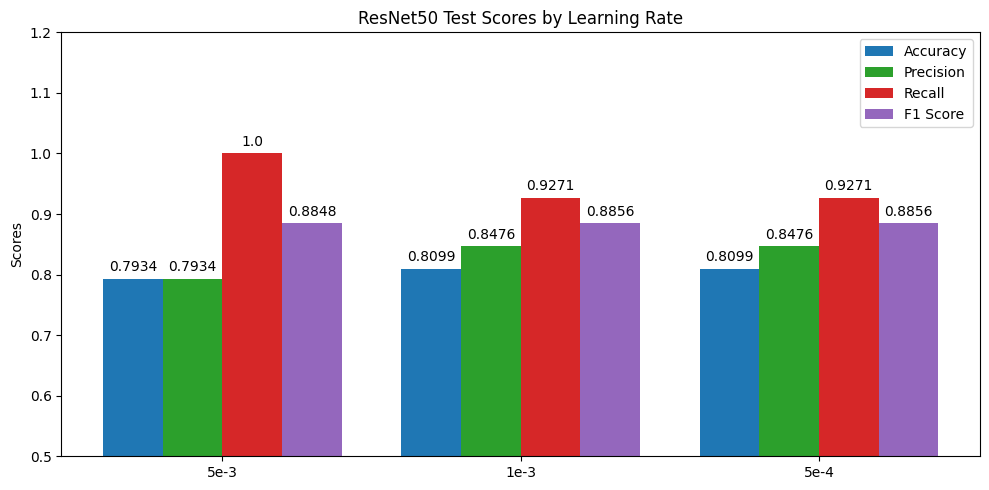

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Learning Rates and their performance metrics
learning_rates = ['5e-3', '1e-3', '5e-4']
accuracy = [0.7934, 0.8099, 0.8099]
precision = [0.7934, 0.8476, 0.8476]
recall = [1.0000, 0.9271, 0.9271]
f1_scores = [0.8848, 0.8856, 0.8856]

x = np.arange(len(learning_rates))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ResNet50 Test Scores by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(learning_rates)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()



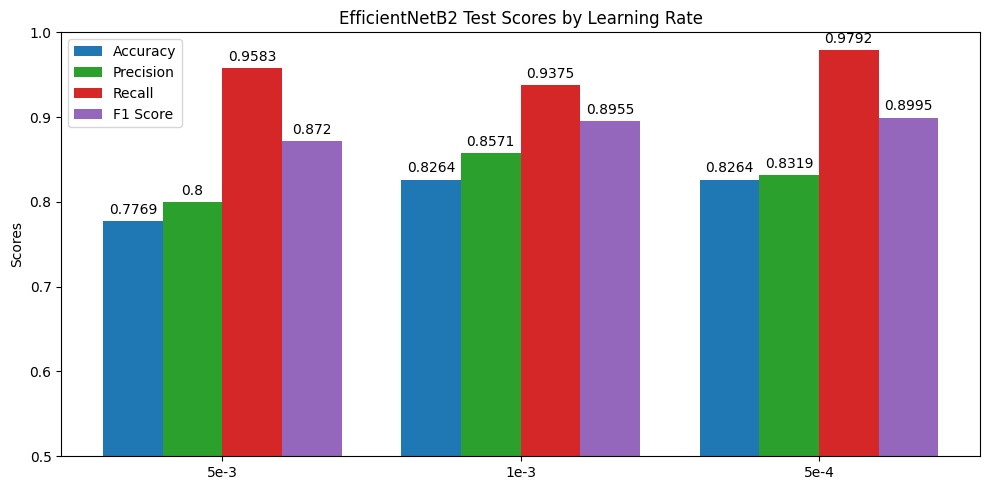

In [22]:
# Learning Rates and their performance metrics for EfficientNetB2
learning_rates = ['5e-3', '1e-3', '5e-4']
accuracy = [0.7769, 0.8264, 0.8264]
precision = [0.8000, 0.8571, 0.8319]
recall = [0.9583, 0.9375, 0.9792]
f1_scores = [0.8720, 0.8955, 0.8995]

x = np.arange(len(learning_rates))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('EfficientNetB2 Test Scores by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(learning_rates)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.0)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()


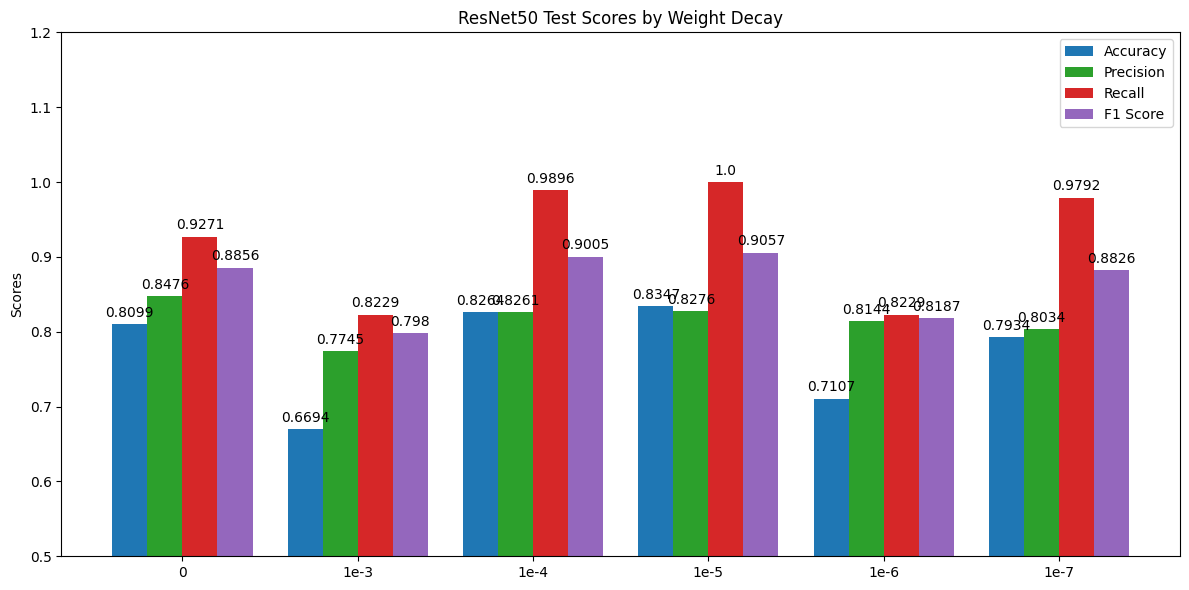

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Weight decay values and their performance metrics
weight_decays = ['0', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7']
accuracy = [0.8099, 0.6694, 0.8264, 0.8347, 0.7107, 0.7934]
precision = [0.8476, 0.7745, 0.8261, 0.8276, 0.8144, 0.8034]
recall = [0.9271, 0.8229, 0.9896, 1.0000, 0.8229, 0.9792]
f1_scores = [0.8856, 0.7980, 0.9005, 0.9057, 0.8187, 0.8826]

x = np.arange(len(weight_decays))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ResNet50 Test Scores by Weight Decay')
ax.set_xticks(x)
ax.set_xticklabels(weight_decays)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()


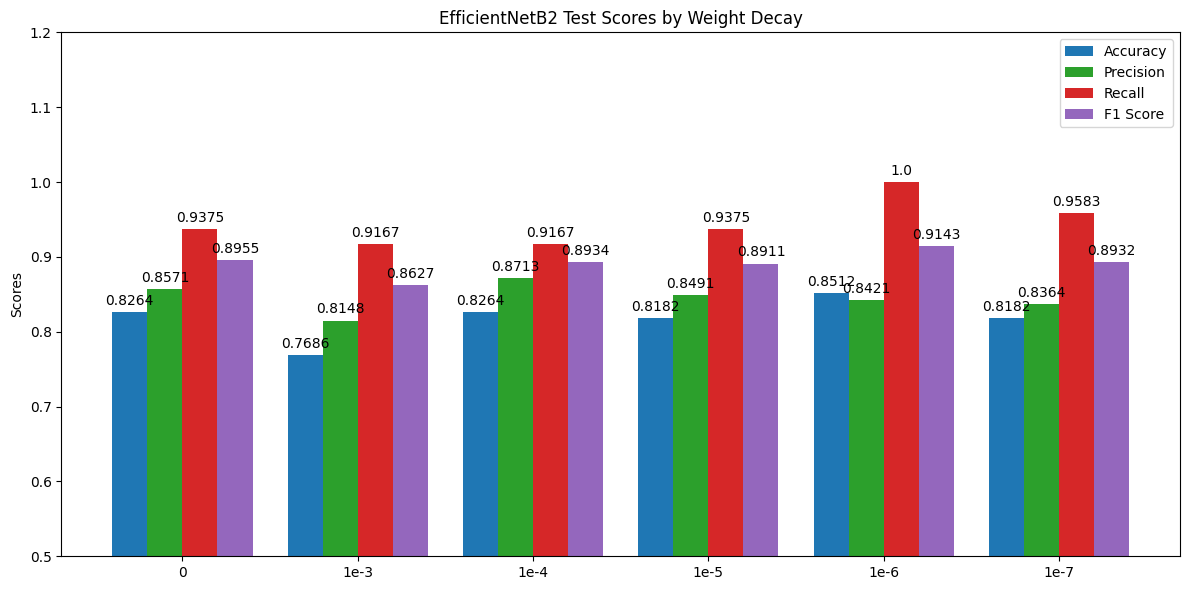

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Weight decay values and their performance metrics for EfficientNetB2
weight_decays = ['0', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7']
accuracy = [0.8264, 0.7686, 0.8264, 0.8182, 0.8512, 0.8182]
precision = [0.8571, 0.8148, 0.8713, 0.8491, 0.8421, 0.8364]
recall = [0.9375, 0.9167, 0.9167, 0.9375, 1.0000, 0.9583]
f1_scores = [0.8955, 0.8627, 0.8934, 0.8911, 0.9143, 0.8932]

x = np.arange(len(weight_decays))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('EfficientNetB2 Test Scores by Weight Decay')
ax.set_xticks(x)
ax.set_xticklabels(weight_decays)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()


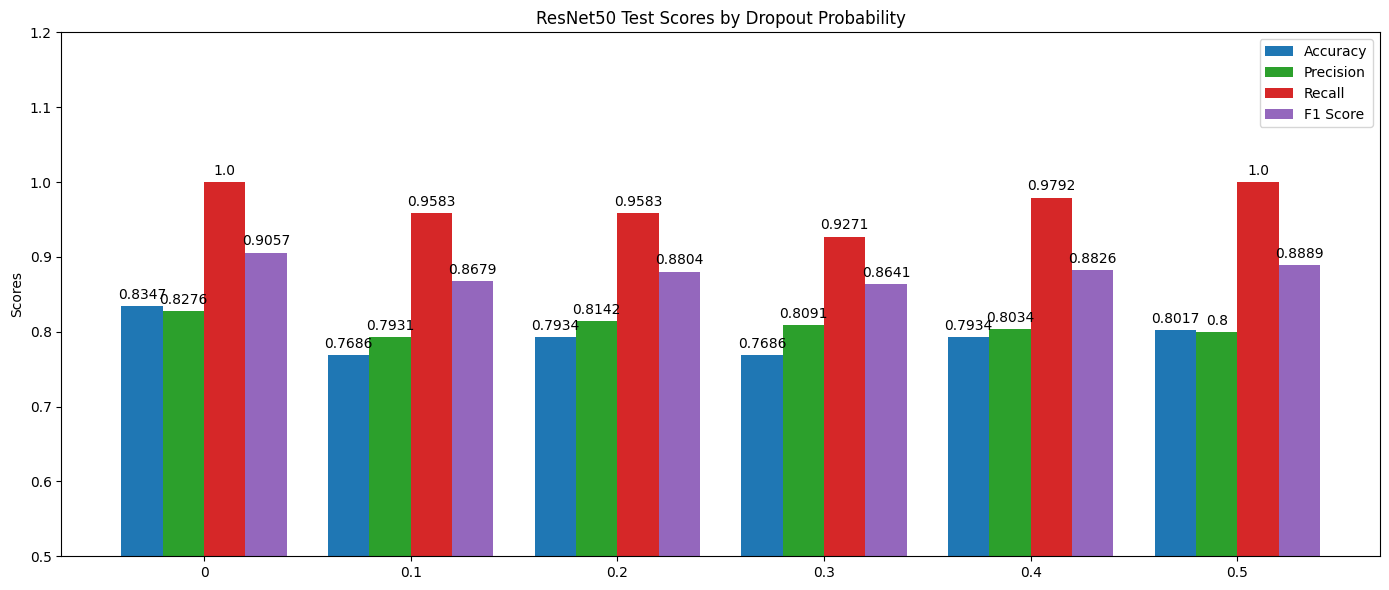

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Dropout probabilities and their respective performance metrics
dropout_probs = ['0', '0.1', '0.2', '0.3', '0.4', '0.5']
accuracy = [0.8347, 0.7686, 0.7934, 0.7686, 0.7934, 0.8017]
precision = [0.8276, 0.7931, 0.8142, 0.8091, 0.8034, 0.8000]
recall = [1.0000, 0.9583, 0.9583, 0.9271, 0.9792, 1.0000]
f1_scores = [0.9057, 0.8679, 0.8804, 0.8641, 0.8826, 0.8889]

x = np.arange(len(dropout_probs))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ResNet50 Test Scores by Dropout Probability')
ax.set_xticks(x)
ax.set_xticklabels(dropout_probs)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()



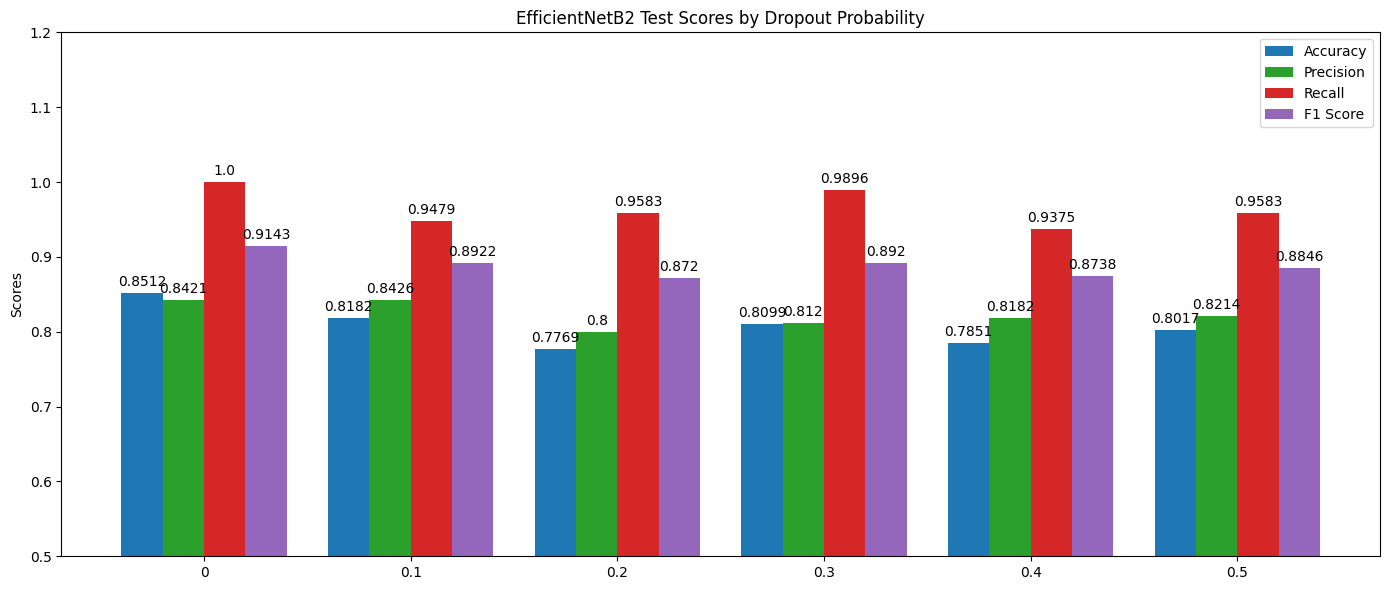

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Dropout probabilities and their respective performance metrics for EfficientNetB2
dropout_probs = ['0', '0.1', '0.2', '0.3', '0.4', '0.5']
accuracy = [0.8512, 0.8182, 0.7769, 0.8099, 0.7851, 0.8017]
precision = [0.8421, 0.8426, 0.8000, 0.8120, 0.8182, 0.8214]
recall = [1.0000, 0.9479, 0.9583, 0.9896, 0.9375, 0.9583]
f1_scores = [0.9143, 0.8922, 0.8720, 0.8920, 0.8738, 0.8846]

x = np.arange(len(dropout_probs))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='tab:blue')
rects2 = ax.bar(x - width/2, precision, width, label='Precision', color='tab:green')
rects3 = ax.bar(x + width/2, recall, width, label='Recall', color='tab:red')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='tab:purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('EfficientNetB2 Test Scores by Dropout Probability')
ax.set_xticks(x)
ax.set_xticklabels(dropout_probs)
ax.legend()

# Setting y-axis limit
ax.set_ylim(0.5, 1.2)  # Set y-axis limits to focus on the range of scores

# Adding bar labels for clear comparison
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(rects1)
add_bar_labels(rects2)
add_bar_labels(rects3)
add_bar_labels(rects4)

fig.tight_layout()
plt.show()
